## Introducción al aprendizaje supervisado

#### IMPORTANTE!!!

INSTALAR:

1) conda install -c conda-forge imbalanced-learn

2) conda install -c anaconda joblib


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import collections
import modelos
import warnings
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import cm
from time import time
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, LabelEncoder, Binarizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from visualization import plot_confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

   
#np.random.seed(23)
warnings.filterwarnings("ignore")

np.random.seed(42)

In [27]:
#funciones

def hiperparametros(X_train,y_train,X_test,y_test,metrica,clf,params):
    model = GridSearchCV(clf, params, cv=5, scoring=metrica)
    model.fit(X_train, y_train)
    
    print('***************************** METRICA: '+metrica.upper()+' *****************************')
    print('\n\n.:HIPERPARÁMETROS DEL MEJOR MODELO:\n\n ',model.best_estimator_,end='\n\n\n') 
        
    print('.:CONJUNTO DE ENTRENAMIENTO\n')
    y_true, y_pred = y_train, model.predict(X_train)
    print(classification_report(y_true, y_pred),'\n')
    
    print('.:CONJUNTO DE TEST\n')
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred),'\n\n\n')
    
    return confusion_matrix(y_train, model.predict(X_train)),confusion_matrix(y_test, model.predict(X_test))

def plots(matriz,labels,metrica,tipo):
    if tipo=='train':
        plot_confusion_matrix(matriz,
                          classes=labels, normalize=False,
                          title='ENTRENAMIENTO\n'+metrica.upper())
    else:
        plot_confusion_matrix(matriz,
                          classes=labels, normalize=False,
                          title='TEST\n'+metrica.upper())

### Actividades:

#### Dataset rain_teodelina

1) agregar features que aporten valor al dataset  

2) Analizar features data / target 

3) dividir dataset (training, validation, test)    

4) analizar y elegir el modelo mas apropiado, entrenarlo y analizar resultados  

5) combinar clasificadores y analizar resultados  

6) evaluar predicciones de los diferentes modelos  

In [6]:
rain_t = pd.read_csv("rain_teodelina.csv", parse_dates = ["date"], index_col=[0])
rain_t.head()

,rain
date,
1978-01-01,0
1978-01-02,0
1978-01-03,0
1978-01-04,0
1978-01-05,0


In [7]:
rain_t.describe(include='all')

,rain
count,15034.000000
mean,3.331914
std,11.451975
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,220.000000


In [8]:
missing_values_count_t = rain_t.isnull().sum()
missing_values_count_t[missing_values_count_t > 0]

Series([], dtype: int64)

In [11]:
rain_t['mes'] = rain_t.index.month
rain_t['año'] = rain_t.index.year
#lluvias['mesHid'] = (lluvias.index.month+5)%12+1
rain_t['añoHid'] = (rain_t.index + dt.timedelta(days=181))
rain_t['mesHid'] = rain_t.añoHid.dt.month

In [43]:
rain_t.describe(include='all')

,rain,mes,año,añoHid,mesHid
count,15034.000000,15034.000000,15034.000000,15034,15034.000000
unique,NaN,NaN,NaN,15034,NaN
top,NaN,NaN,NaN,1989-12-27 00:00:00,NaN
freq,NaN,NaN,NaN,1,NaN
first,NaN,NaN,NaN,1978-07-01 00:00:00,NaN
last,NaN,NaN,NaN,2019-08-28 00:00:00,NaN
mean,3.331914,6.503193,1998.082413,NaN,6.526739
std,11.451975,3.456608,11.881857,NaN,3.442680
min,0.000000,1.000000,1978.000000,NaN,1.000000
25%,0.000000,3.250000,1988.000000,NaN,4.000000


In [44]:
AcumMensual = pd.pivot_table(rain_t, values='rain', index=['año'],columns=['mes'], aggfunc=np.sum, margins=True)

In [45]:
sumas_short = AcumMensual.drop(['All'], axis=1)
sumas_short = sumas_short.drop([2019,'All'], axis=0)
sumas_short

mes,1,2,3,4,5,6,7,8,9,10,11,12
año,,,,,,,,,,,,
1978,217.0,140.0,204.0,77.0,29.0,16.0,68.0,22.0,303.0,132.0,235.0,50.0
1979,110.0,173.0,166.0,89.0,14.0,47.0,17.0,9.0,29.0,69.0,190.0,120.0
1980,21.0,113.0,214.0,174.0,30.0,54.0,11.0,5.0,17.0,173.0,112.0,107.0
1981,297.0,108.0,179.0,92.0,82.0,35.0,16.0,1.0,47.0,103.0,147.0,81.0
1982,228.0,199.0,103.0,111.0,3.0,26.0,13.0,0.0,107.0,31.0,133.0,52.0
1983,113.0,148.0,52.0,86.0,50.0,6.0,5.0,32.0,11.0,202.0,127.0,40.0
1984,203.0,365.0,113.0,39.0,30.0,12.0,12.0,24.0,74.0,160.0,105.0,81.0
1985,83.0,149.0,61.0,82.0,62.0,0.0,85.0,36.0,71.0,158.0,147.0,75.0
1986,331.0,50.0,37.0,139.0,22.0,40.0,6.0,31.0,79.0,150.0,131.0,16.0


In [46]:
precipitation = rain_t.rain

consecutive_dry = [1 if data == 0 else 0 for data in precipitation]
for i in range(1, len(consecutive_dry)):
    if consecutive_dry[i] == 1:
        consecutive_dry[i] += consecutive_dry[i - 1]
        
consecutive_wet = [1 if data > 0 else 0 for data in precipitation]
for i in range(1, len(consecutive_wet)):
    if consecutive_wet[i] == 1:
        consecutive_wet[i] += consecutive_wet[i - 1]
        #inicio maru
        #if consecutive_wet[i] ==1:
        #    consecutive_dry[i] = consecutive_dry[i-1]
        #else:
        #    if consecutive_dry[i-1]-1 < 0:
        #        consecutive_dry[i] = 0
        #    else:
        #        consecutive_dry[i] = consecutive_dry[i-1]-1
        #fin maru

rain_t['cons_dry'] = consecutive_dry
rain_t['cons_wet'] = consecutive_wet

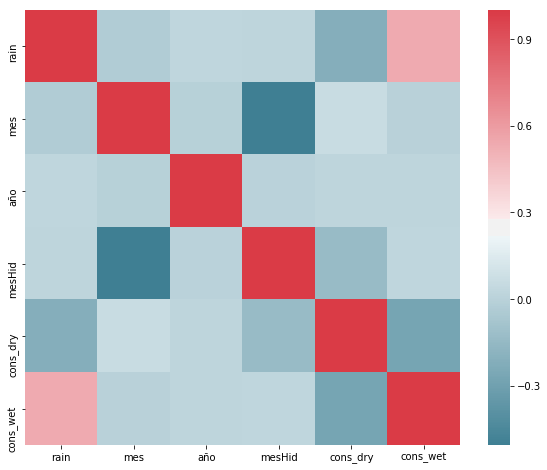

In [47]:
corr_t = rain_t.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_t, mask=np.zeros_like(corr_t, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

In [48]:
y_orig = rain_t['rain']  #columnas objetivo
X_orig = rain_t.drop('rain', axis=1)  #columnas independientes

In [49]:
X2 = X_orig.drop('añoHid', axis=1)
X3 = np.around(X2, decimals = 0, out = None)
X3 = X3.astype(int)
y3 = np.around(y_orig, decimals = 0, out = None)
y3 = y3.astype(int)

In [50]:
# split training dataset into test and train 
# (we won't be using testing sets here, because of the cross-validation; but it couldn be useful)
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.3, random_state=42) ##test_size conviene 0.2???

In [51]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class = 'auto', random_state = 42)
lr_param = {'penalty':('l2', 'l1'), 'C':[1.0], 'warm_start':[True, False]}

lr_clf = GridSearchCV(lr, lr_param, cv=5, iid=False)
start = time()
lr_clf.fit(X_train, y_train)
best_lr_clf = lr_clf.best_estimator_
print('Best Log Reg: ', lr_clf.best_score_)
print(best_lr_clf)
results = results.append({'clf': best_lr_clf, 'best_res': lr_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])

print("Log Reg tomó %.2f segundos para %d configuraciones de parámetros candidatos."
      % (time() - start, len(lr_clf.cv_results_['params'])))
for i in range(len(lr_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(lr_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  lr_clf.cv_results_['mean_test_score'][candidato],
                  lr_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(lr_clf.cv_results_['params'][candidato]))
        print("")


/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarni

Best Log Reg:  0.8498338279385955
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=True)
The best classifier so far is: 
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=True)
Log Reg tomó 52.74 segundos para 4 configuraciones de parámetros candidatos.
El modelo con el ranking: 1
Scores de validación Medios: 0.850 (std: 0.012)
Parametros: {'C': 1.0, 'penalty': 'l1', 'warm_start': True}

El modelo con el ranking: 1
Scores de validación Medios: 0.850 (std: 0.012)
Parametros: {'C': 1.0, 'penalty': 'l1', 'warm_start': False}

El modelo con el ranking: 3
Scores de validación Medios: 0.8

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [52]:
from sklearn.linear_model import LogisticRegression

results = pd.DataFrame(columns=('clf', 'best_res'))

lr_clf2 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=True)

lr_clf2.fit(X_train, y_train)
results = results.append({'clf': lr_clf2}, ignore_index=True)

print('Logistic Regression:')
print('Score para entrenamiento: %.2f' % 
      accuracy_score(y_train, lr_clf2.predict(X_train)))
print('Score para evaluación: %.2f' %
      accuracy_score(y_test, lr_clf2.predict(X_test)))

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression:
Score para entrenamiento: 0.85
Score para evaluación: 0.84


In [123]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Stochastic Gradient
from sklearn.linear_model import SGDClassifier


#parameters_SGDC = {'loss':('hinge', 'log'), 'max_iter': [10000], 'tol': [0.001]}
parameters_SGDC = {'loss':('hinge', 'log'), 'learning_rate':('adaptive', 'optimal', 'invscaling'),
              'penalty':('l2', 'l1', 'elasticnet'), 'alpha':[0.0001], 'max_iter': [10000], 
              'eta0': [0.1], 'tol': [0.001]}
SGDC = SGDClassifier(random_state=42)
SGDC_clf = GridSearchCV(SGDC, parameters_SGDC, cv=5, iid = False, return_train_score = True)
start = time()
SGDC_clf.fit(X_train, y_train)
best_SGDC_clf = SGDC_clf.best_estimator_

print('Best SGDC score: ', SGDC_clf.best_score_)
print(best_SGDC_clf)
results = results.append({'clf': best_SGDC_clf, 'best_res': SGDC_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])
print("")

print("GridSearchCV tomó %.2f segundos para %d configuraciones de parámetros candidatos."
      % (time() - start, len(SGDC_clf.cv_results_['params'])))
for i in range(len(SGDC_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(SGDC_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  SGDC_clf.cv_results_['mean_test_score'][candidato],
                  SGDC_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(SGDC_clf.cv_results_['params'][candidato]))
        print("")

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best SGDC score:  0.844255405679211
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge',
       max_iter=10000, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l1', power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)
The best classifier so far is: 
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge',
       max_iter=10000, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l1', power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

GridSearchCV tomó 2370.59 segundos para 18 configuraciones de parámetros candidatos.
El modelo con el ranking: 1
Scores de valida

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [124]:
from sklearn.linear_model import SGDClassifier

results = pd.DataFrame(columns=('clf', 'best_res'))

SGDC_clf2 = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge',
       max_iter=10000, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l1', power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

SGDC_clf2.fit(X_train, y_train)
results = results.append({'clf': SGDC_clf2}, ignore_index=True)

print('Stochastic Descendent Gradient:')
print('Score para entrenamiento: %.2f' % 
      accuracy_score(y_train, SGDC_clf2.predict(X_train)))
print('Score para evaluación: %.2f' %
      accuracy_score(y_test, SGDC_clf2.predict(X_test)))

Stochastic Descendent Gradient:
Score para entrenamiento: 0.84
Score para evaluación: 0.83


/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [4]:
mis_colores = ['gray','skyblue','mediumturquoise','dodgerblue','royalblue','navy']
meses_secos = [5,6,7,8,9]

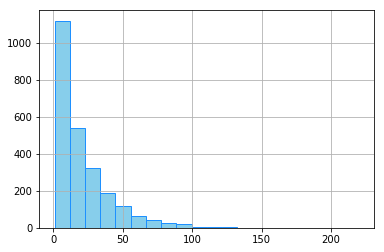

In [9]:
rain_t[rain_t.rain>0].rain.hist(bins=20,color=mis_colores[1],edgecolor=mis_colores[3])

### Observación: 
Se llevarán a cabo dos tipos de análisis:
- Por un lado un análisis de clasificación binaria: Llueve? Sí/No, para ello se genera el *feature* correspondiente
- Por otro lado, dado que pueden visualizarse por lo menos cuatro clases de lluvias, se llevará a cabo el análisis de clasificación multiclase: Cuánto llueve? Para lo cual se genera un nuevo *feature* con la clases:

  - Nada              lluvia = 0
  - Débiles 	      lluvia ≤ 2
  - Moderadas 	 2  < lluvia ≤ 15
  -	Fuertes 	 15 < lluvia ≤ 30 
  -	Muy fuertes  30 < lluvia ≤ 60
  -	Torrenciales 	  lluvia >60 

In [12]:
rain_nuevo                = rain_t.copy()
rain_nuevo['dia_año']     = rain_nuevo.index.dayofyear
rain_nuevo['temporada']   = np.where(rain_nuevo.mes.isin(meses_secos),0,1)
rain_nuevo['mes_str']     = rain_nuevo.index.month_name()
rain_nuevo['lluvia']      = np.where(rain_t.rain!=0,1,0)
rangos = [-1,0,2,15,
          30,60,np.inf]
clases = ['nada',
          'debil',
          'moderada',
          'fuerte',
          'muy fuerte',
          'torrencial']
rain_nuevo['lluvia_clase'] = pd.cut(rain_nuevo['rain'],rangos,labels=clases)

Text(0, 0.5, 'LLUVIA [mm]')

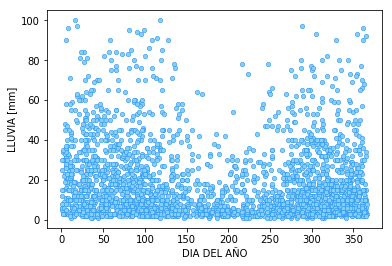

In [14]:
lim_sup=100
plt.scatter(rain_nuevo[(rain_nuevo.rain>0)&(rain_nuevo.rain<=lim_sup)].dia_año,
            rain_nuevo[(rain_nuevo.rain>0)&(rain_nuevo.rain<=lim_sup)].rain,
            s=20,
            color=mis_colores[1],
            edgecolors=mis_colores[3],lw=0.5)
plt.xlabel('DIA DEL AÑO')
plt.ylabel('LLUVIA [mm]')

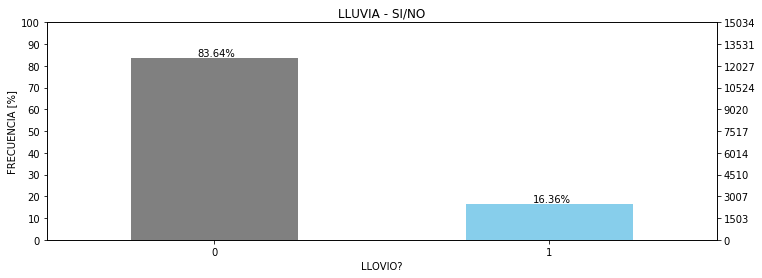

In [15]:
plt.figure(figsize=(12,4))
plt.title('LLUVIA - SI/NO')
plt.xlabel('LLOVIO?')
plt.ylabel('FRECUENCIA [%]')

ax = (rain_nuevo.lluvia.value_counts()/len(rain_nuevo)*100).sort_index().plot(kind="bar", rot=0,color=mis_colores[:2])
ax.set_yticks(np.arange(0, 110, 10))

ax2 = ax.twinx()
ax2.set_yticks(np.arange(0, 110, 10)*len(rain_nuevo)/100)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.20, p.get_height()+1))

### OBSERVACIÓN:
Estamos ante un *dataset* fuertemente desbalanceado

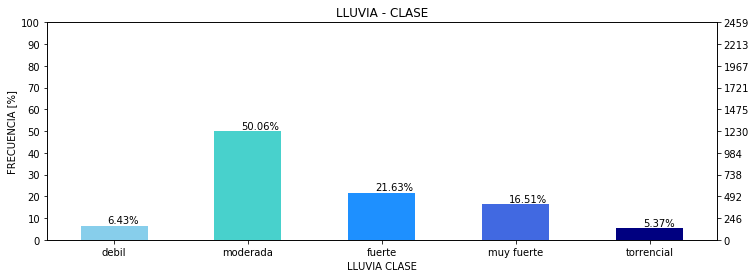

In [16]:
plt.figure(figsize=(12,4))
plt.title('LLUVIA - CLASE')
plt.xlabel('LLUVIA CLASE')
plt.ylabel('FRECUENCIA [%]')

lluvia_si = rain_nuevo[rain_nuevo.lluvia_clase!='nada'] 

ax = (lluvia_si.lluvia_clase.value_counts()[:-1]/len(lluvia_si)*100).sort_index().plot(kind="bar", rot=0,color=mis_colores[1:])
ax.set_yticks(np.arange(0, 110, 10))

ax2 = ax.twinx()
ax2.set_yticks(np.arange(0, 110, 10)*len(lluvia_si)/100)

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.20, p.get_height()+1))

In [17]:
dias = []
ndias = 30

for i in range(ndias):
    dias.append([0]*len(rain_nuevo))
    
# se agregan columnas de dias anteriores con lluvia:1 sin lluvia:0 
# se las denomina diasi donde i indica re refiere al i-esimo dia desde el actual
# ejemplo: dias3 informa si llovio hace tres dias atras, dias5 si llovio hace cinco, dias1 si llovio ayer, etc
for i in range(len(rain_nuevo)):
    if rain_nuevo.lluvia.values[i]==1:
        for j in range(ndias):
            if i+j+1 < len(rain_nuevo):
                dias[j][i+j+1] = 1
            else: continue
                
columnas = ['lluvia']
for i in range(1,ndias+1):
    dias_str = 'dias'+str(i)
    columnas.append(dias_str)
    rain_nuevo[dias_str] = dias[i-1]
    
rain_nuevo[rain_nuevo.lluvia==1][columnas].head(10)   

,lluvia,dias1,dias2,dias3,dias4,dias5,dias6,dias7,dias8,dias9,...,dias21,dias22,dias23,dias24,dias25,dias26,dias27,dias28,dias29,dias30
date,,,,,,,,,,,,,,,,,,,,,
1978-01-12,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1978-01-13,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1978-01-19,1,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1978-01-22,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1978-01-25,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1978-01-28,1,0,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1978-01-29,1,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1978-01-30,1,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1978-02-08,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,0,0,0


In [18]:
#atributos_analisis = ['mes_str','cons_dry','cons_wet']
#atributos_analisis = ['mes_str','dia_año','temporada']+['dias'+str(i) for i in range(1,ndias+1)]
atributos_analisis = ['mes_str']+['dias'+str(i) for i in range(1,ndias+1)]

In [19]:
# division atributos de analisis y etiquetas
X,y1,y2 = rain_nuevo[atributos_analisis],rain_nuevo[['lluvia']],rain_nuevo[['lluvia_clase']]

In [20]:
# normalizo dia del año
#X.dia_año = (X.dia_año-X.dia_año.min())/(X.dia_año.max()-X.dia_año.min())

# binarizo categoricas
X = pd.get_dummies(X)

# divido en conjuntos de entrenamiento y prueba
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=23)
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=23)

In [21]:
labels = ['NO LLUEVE','LLUEVE']
clases = list(rain_nuevo.lluvia_clase.unique())

In [22]:
dic = modelos.modelo_familia()
modelos.modelo_familia()

{'LINEAL': {1: 'LogisticRegression',
  2: 'RidgeClassifier',
  3: 'SGDClassifier',
  4: 'Perceptron',
  5: 'PassiveAggressiveClassifier'},
 'SVM': {1: 'LinearSVC', 2: 'NuSVC', 3: 'SVC'},
 'TREE': {1: 'DecisionTreeClassifier'},
 'NEIGHBORS': {1: 'KNeighborsClassifier',
  2: 'NearestCentroid',
  3: 'RadiusNeighborsClassifier'},
 'SEMI_SUPERVISED': {1: 'LabelPropagation', 2: 'LabelSpreading'},
 'ENSEMBLE': {1: 'RandomForestClassifier'},
 'DISCRIMINANT_ANALYSIS': {1: 'LinearDiscriminantAnalysis',
  2: 'QuadraticDiscriminantAnalysis'},
 'NEURAL_NETWORK': {1: 'MLPClassifier'}}

In [23]:
n = 10
alphas= np.logspace(-4, 1, n)
etas= np.logspace(-4, 1, n)

loss_function = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
metrics = ['accuracy','precision','recall','f1','roc_auc']

In [25]:
m = 0
sm = 3
modelo=list(dic.keys())[m]
clf,params = modelos.get_modelo(113,modelo,sm)
params = {'loss': ('hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'),
          'penalty': ['l2'],
          'learning_rate': ('optimal','adaptive','constant'),
          'alpha': alphas,
          'eta0': etas,
          }


In [28]:
matrices = []

for idx, metrica in enumerate(metrics, start=1):
    mtrain,mtest = hiperparametros(X1_train,y1_train,X1_test,y1_test,metrica,clf,params)
    matrices.append(mtrain)
    matrices.append(mtest)

***************************** METRICA: ACCURACY *****************************


.:HIPERPARÁMETROS DEL MEJOR MODELO:

  SGDClassifier(alpha=0.21544346900318845, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.21544346900318845,
       fit_intercept=True, l1_ratio=0.15, learning_rate='adaptive',
       loss='hinge', max_iter=None, n_iter=None, n_iter_no_change=5,
       n_jobs=None, penalty='l2', power_t=0.5, random_state=113,
       shuffle=True, tol=None, validation_fraction=0.1, verbose=0,
       warm_start=False)


.:CONJUNTO DE ENTRENAMIENTO

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     10066
           1       0.00      0.00      0.00      1961

   micro avg       0.84      0.84      0.84     12027
   macro avg       0.42      0.50      0.46     12027
weighted avg       0.70      0.84      0.76     12027
 

.:CONJUNTO DE TEST

              precision    recall  f1-score   support

         

[]

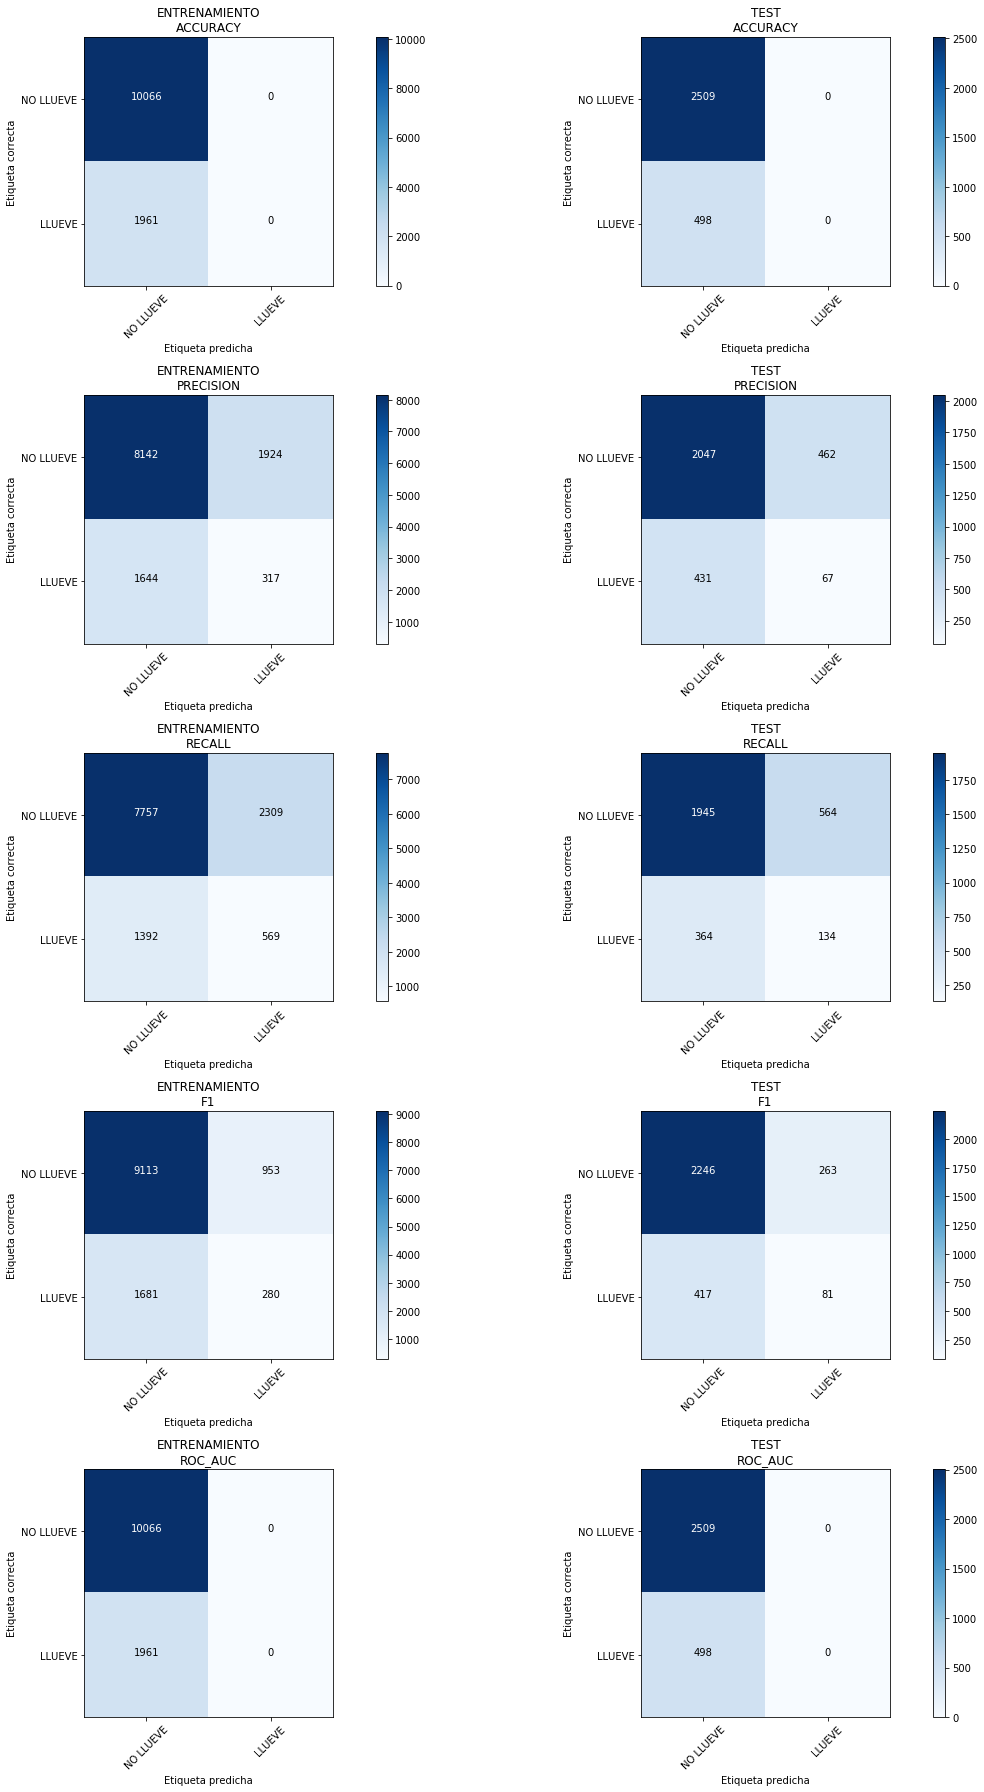

In [29]:
plt.figure(figsize=(20,25))
for idx, metrica in enumerate(metrics, start=0):
    plt.subplot(5,2,2*idx+1)
    plots(matrices[2*idx],labels,metrica,'train')
    plt.subplot(5,2,2*(idx+1))
    plots(matrices[2*idx+1],labels,metrica,'test')
plt.plot()  

### PRIMEROS RESULTADOS:
- Se observa que al considerar distintas métricas en el scoring de la búsqueda de hiperparámetros, los resultados varían notablemente.
- Se puede ver que todas las métricas devuelven puntajes altos sobre la clase dominante, lo cual es esperable. 
- Para la clase minoritaria, las métricas: *accuracy* y *auc-roc* no son capaces de predecir días lluviosos, lo cual es esperable pues, por lo menos se sabe que *accuracy* no funciona bien cuando se quiere tener buena predicción de la clase minoritaria en un *dataset* desbalanceado.
- Las métricas: *precision*, *recall* y *f1-score* mejoran notablemente porque por lo menos predicen días lluviosos, si bien la performance es baja, son capaces de diferenciarlas. La mejor precisión se obtiene con la métrica *recall*, pero la misma produce una baja en los puntajes de la clase dominante y genera un exceso de prediccciones sobre la clase minoritaria, por otro lado, *f1-score* devuelve una menor precisión bajando de 0.29 a 0.16, pero mantiene alto los puntajes de la clase mayoritaria.

Dependiendo del objetivo de la predicción, uno elegirá cuál es el mejor modelo, ya sea si se desea minimizar el error tipo 1 o el tipo 2


###### VEAMOS QUÉ OCURRE SI BALANCEAMOS LAS CLASES, YA SEA POR *UNDERSAMPLING* U *OVERSAMPLING*

Text(0.5, 1.0, 'OVERSAMPLING')

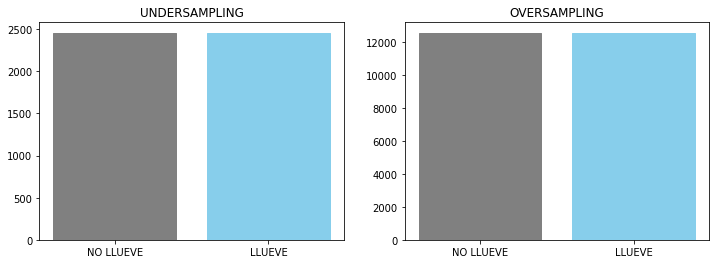

In [30]:
rus = RandomUnderSampler(return_indices=True)
ros = RandomOverSampler()

X_rus, y_rus, id_rus = rus.fit_sample(X, y1)
X_ros, y_ros = ros.fit_sample(X, y1)

barras_rus = collections.Counter(y_rus.T[0])
barras_ros = collections.Counter(y_ros)
valores_rus = list(barras_rus.values())
valores_ros = list(barras_ros.values())

plt.figure(figsize=(12,4))
plt.subplot(121)
p = plt.bar(labels, valores_rus)
p[0].set_color(mis_colores[0])
p[1].set_color(mis_colores[1])
plt.title('UNDERSAMPLING')
plt.subplot(122)
p = plt.bar(labels, valores_ros)
p[0].set_color(mis_colores[0])
p[1].set_color(mis_colores[1])
plt.title('OVERSAMPLING')

In [31]:
matricesRUS = []
XRUS_train, XRUS_test, yRUS_train, yRUS_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=23)
for idx, metrica in enumerate(metrics, start=1):
    mtrain,mtest = hiperparametros(XRUS_train,
                                   yRUS_train,
                                   XRUS_test,
                                   yRUS_test,
                                   metrica,clf,params)
    matricesRUS.append(mtrain)
    matricesRUS.append(mtest)

***************************** METRICA: ACCURACY *****************************


.:HIPERPARÁMETROS DEL MEJOR MODELO:

  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.004641588833612782,
       fit_intercept=True, l1_ratio=0.15, learning_rate='adaptive',
       loss='hinge', max_iter=None, n_iter=None, n_iter_no_change=5,
       n_jobs=None, penalty='l2', power_t=0.5, random_state=113,
       shuffle=True, tol=None, validation_fraction=0.1, verbose=0,
       warm_start=False)


.:CONJUNTO DE ENTRENAMIENTO

              precision    recall  f1-score   support

           0       0.64      0.47      0.54      1956
           1       0.59      0.75      0.66      1978

   micro avg       0.61      0.61      0.61      3934
   macro avg       0.62      0.61      0.60      3934
weighted avg       0.62      0.61      0.60      3934
 

.:CONJUNTO DE TEST

              precision    recall  f1-score   support

           0       0.

[]

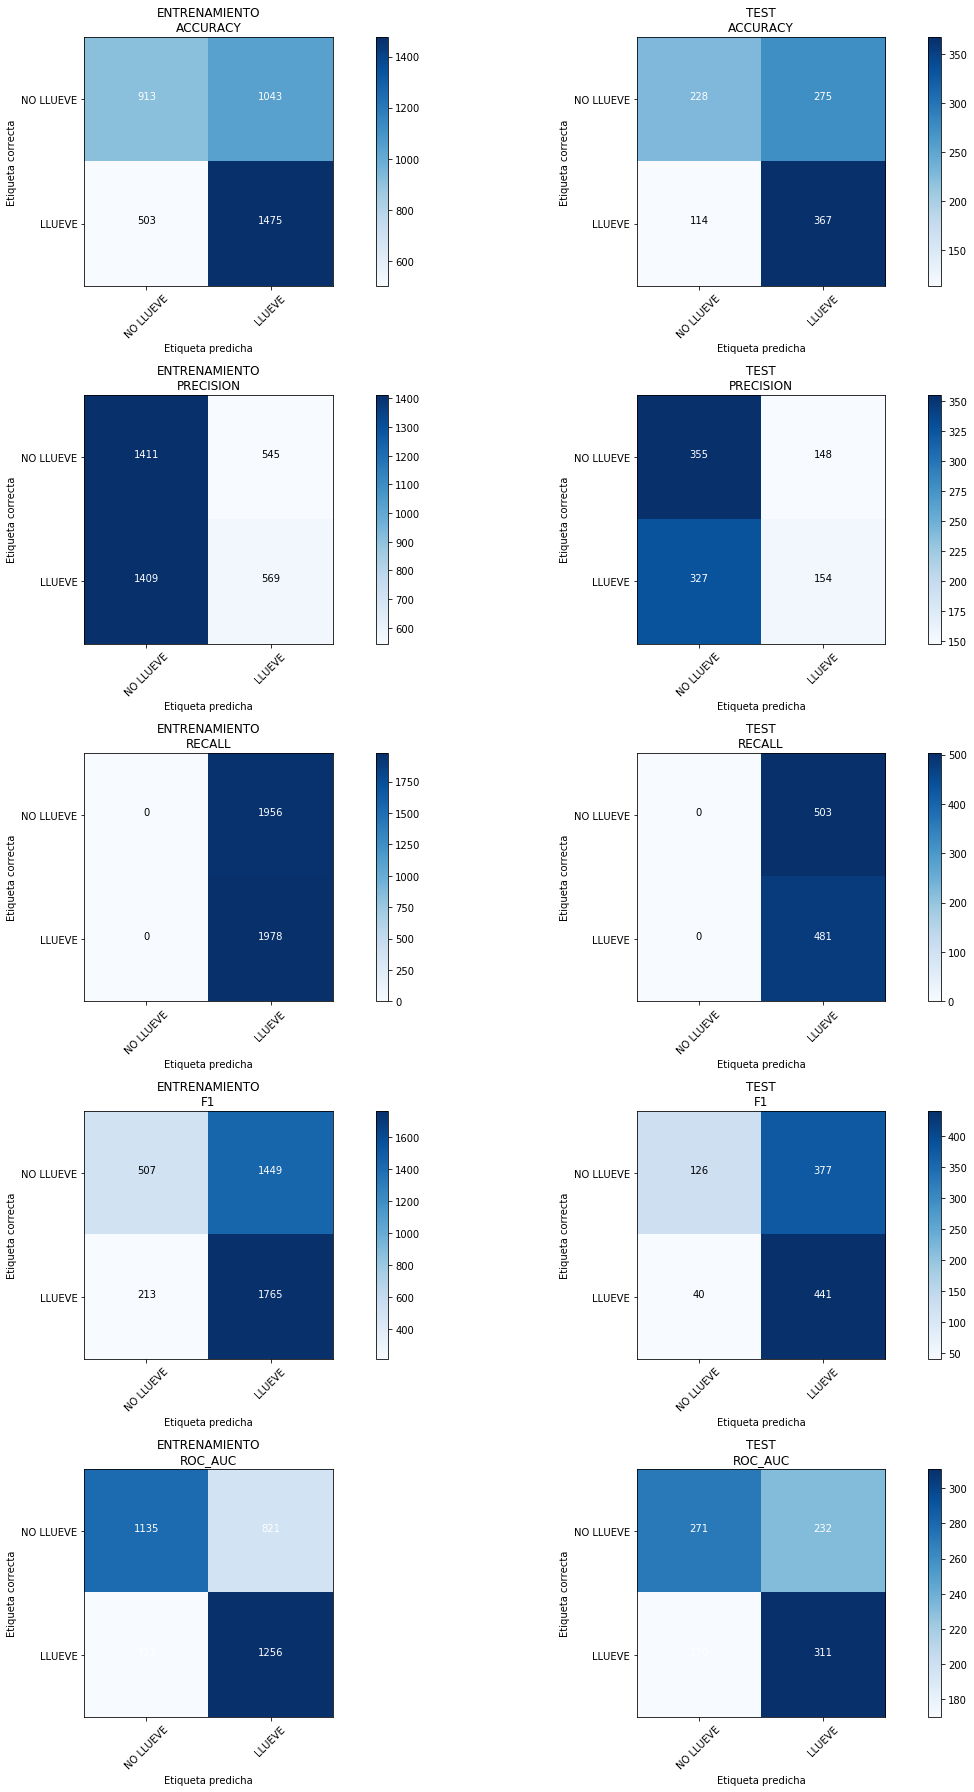

In [32]:
plt.figure(figsize=(20,25))
for idx, metrica in enumerate(metrics, start=0):
    plt.subplot(5,2,2*idx+1)
    plots(matricesRUS[2*idx],labels,metrica,'train')
    plt.subplot(5,2,2*(idx+1))
    plots(matricesRUS[2*idx+1],labels,metrica,'test')
plt.plot() 

### RESULTADOS SUBMUESTREO:
Se observa que los puntajes en las predicciones de días lluviosos aumentan notablemente al balancear las clases por submuestreo, llegando a triplicar los obtenidos sobre el *dataset* original, pero en todos los casos se obtiene una sobre predicción de la clase minoritaria tal, que aproximadamente el 50% resulta una mala predicción de lluvia. Por lo tanto, la performance (bajo el clasificador utilizado) mejora respecto al *dataset* desbalanceado, pero no es suficiente.

In [33]:
matricesROS = []
XROS_train, XROS_test, yROS_train, yROS_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=23)
for idx, metrica in enumerate(metrics, start=1):
    mtrain,mtest = hiperparametros(XROS_train,
                                   yROS_train,
                                   XROS_test,
                                   yROS_test,
                                   metrica,clf,params)
    matricesROS.append(mtrain)
    matricesROS.append(mtest)

***************************** METRICA: ACCURACY *****************************


.:HIPERPARÁMETROS DEL MEJOR MODELO:

  SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.00035938136638046257,
       fit_intercept=True, l1_ratio=0.15, learning_rate='adaptive',
       loss='modified_huber', max_iter=None, n_iter=None,
       n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
       random_state=113, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)


.:CONJUNTO DE ENTRENAMIENTO

              precision    recall  f1-score   support

           0       0.61      0.60      0.61     10074
           1       0.61      0.62      0.61     10046

   micro avg       0.61      0.61      0.61     20120
   macro avg       0.61      0.61      0.61     20120
weighted avg       0.61      0.61      0.61     20120
 

.:CONJUNTO DE TEST

              precision    recall  f1-score   support

          

[]

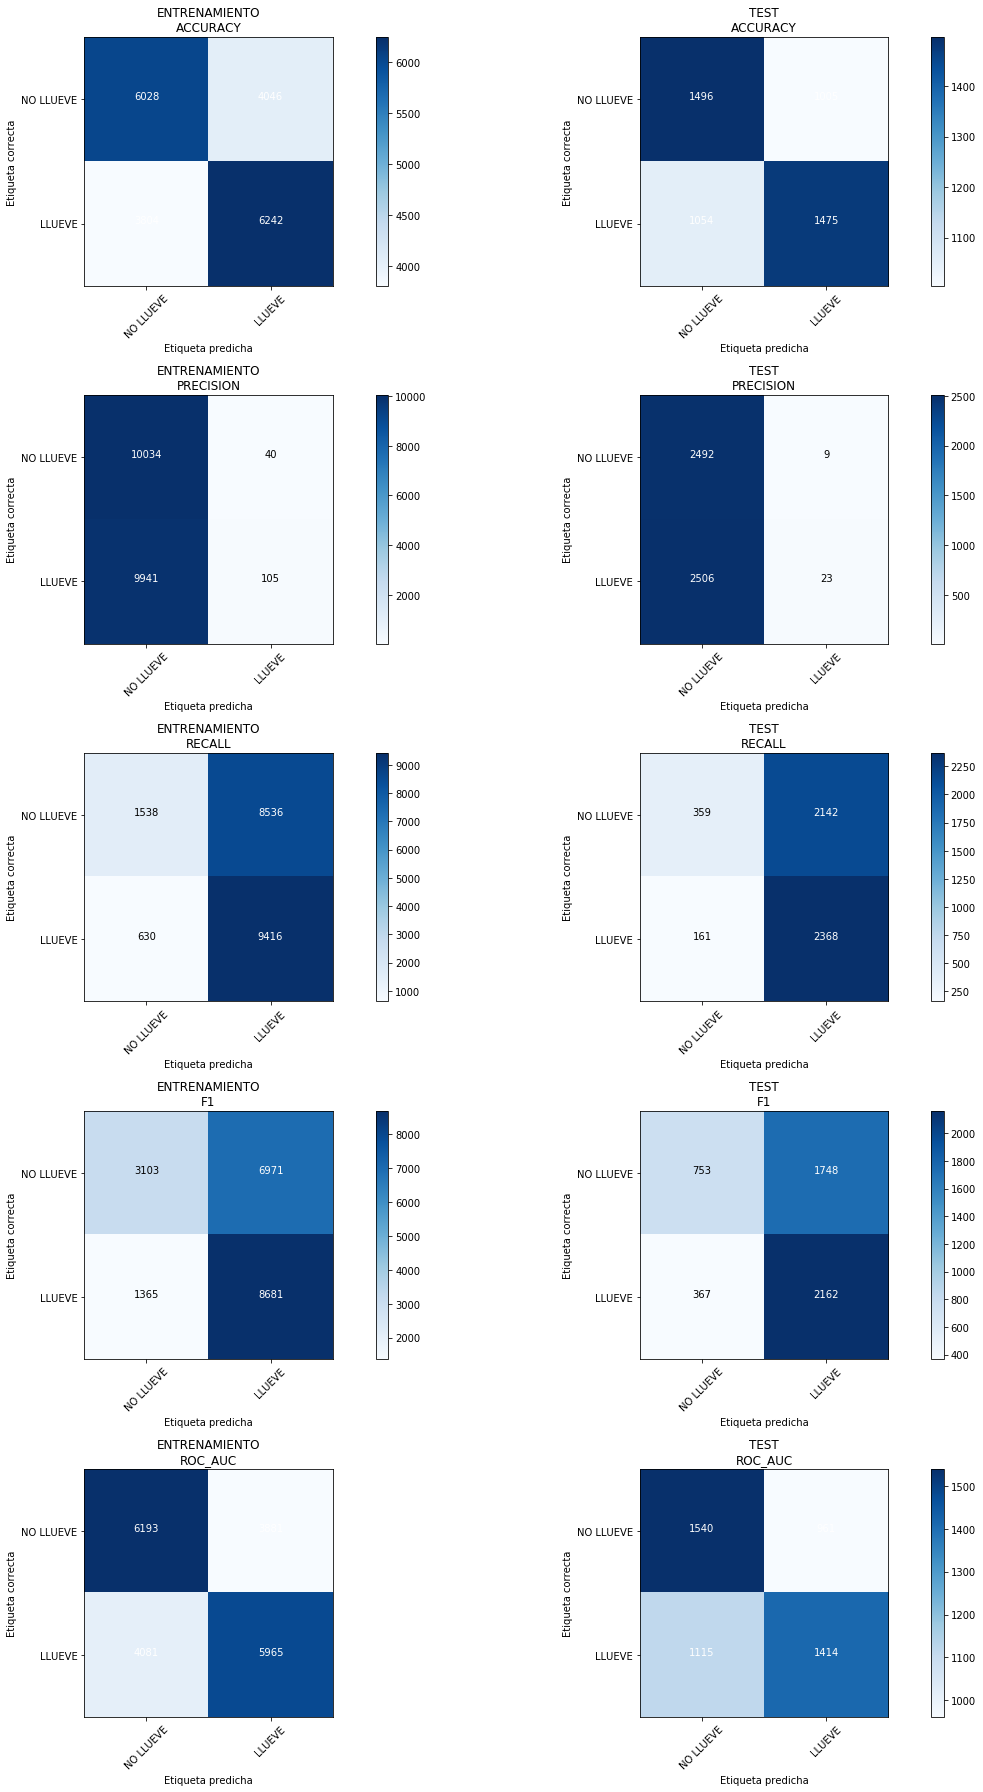

In [34]:
plt.figure(figsize=(20,25))
for idx, metrica in enumerate(metrics, start=0):
    plt.subplot(5,2,2*idx+1)
    plots(matricesROS[2*idx],labels,metrica,'train')
    plt.subplot(5,2,2*(idx+1))
    plots(matricesROS[2*idx+1],labels,metrica,'test')
plt.plot()  

### RESULTADOS SOBREMUESTREO:
Al igual que para el *dataset* submuestreado, se observa que, si bien la precisión de la clase bajo estudio aumenta, en general, los puntajes de la clase mayoritarias disminuyen en *recall* y *f1-score*, esto quiere decir que se predicen más días lluviosos de los que se debiera predecir y nuevamente el porcentaje de error tipo 2 es grande.

### Cambio de modelo: Random Forest

In [35]:
m = 5
sm = 1
modelo=list(dic.keys())[m]
clf,params = modelos.get_modelo(113,modelo,sm)
params = {'criterion':('gini', 'entropy'), 'n_estimators':(100, 500)}

In [36]:
mtrain,mtest = hiperparametros(X1_train,y1_train,X1_test,y1_test,metrics[3],clf,params)

***************************** METRICA: F1 *****************************


.:HIPERPARÁMETROS DEL MEJOR MODELO:

  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=113, verbose=0, warm_start=False)


.:CONJUNTO DE ENTRENAMIENTO

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10066
           1       1.00      0.92      0.96      1961

   micro avg       0.99      0.99      0.99     12027
   macro avg       0.99      0.96      0.97     12027
weighted avg       0.99      0.99      0.99     12027
 

.:CONJUNTO DE TEST

              precision    recall  f1-score   support

           0       0.83      0.99      0

[]

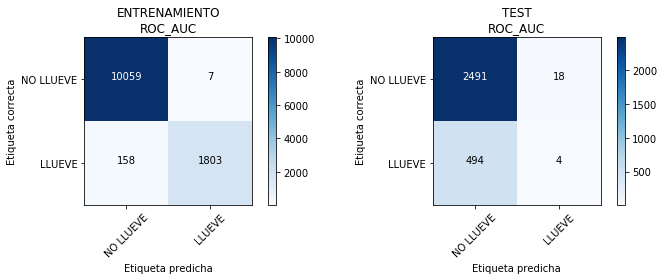

In [37]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plots(mtrain,labels,metrica,'train')
plt.subplot(1,2,2)
plots(mtest,labels,metrica,'test')
plt.plot()  

### RESULTADO RF SOBRE BASE ORIGINAL:
Se observa que memoriza, pues hace un excelente trabajo sobre el conjunto de entrenamiento pero al ponerlo a prueba bajo el conjunto de test, fracasa rotundamente. Veamos qué sucede si utilizamos el *dataset* balanceado por *oversampling*

In [38]:
mtrainROS,mtestROS = hiperparametros(XROS_train,yROS_train,XROS_test,yROS_test,metrics[0],clf,params)

***************************** METRICA: ACCURACY *****************************


.:HIPERPARÁMETROS DEL MEJOR MODELO:

  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=113, verbose=0, warm_start=False)


.:CONJUNTO DE ENTRENAMIENTO

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     10074
           1       0.98      0.97      0.98     10046

   micro avg       0.98      0.98      0.98     20120
   macro avg       0.98      0.98      0.98     20120
weighted avg       0.98      0.98      0.98     20120
 

.:CONJUNTO DE TEST

              precision    recall  f1-score   support

           0       0.95      0.

[]

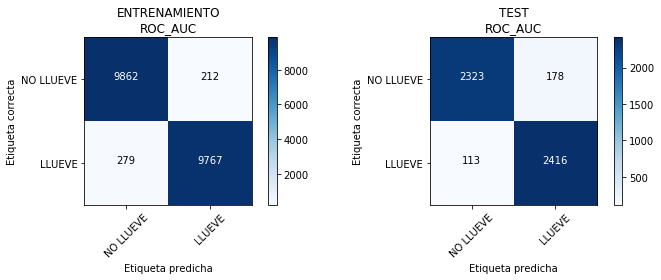

In [39]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plots(mtrainROS,labels,metrica,'train')
plt.subplot(1,2,2)
plots(mtestROS,labels,metrica,'test')
plt.plot() 

### RESULTADO RF SOBRE BASE BALANCEADA POR OVERSAMPLING:
Se observa que el mejor modelo de *Random Forest* junto al *dataset* balanceado por *oversampling* devuelve una performance extremadamente buena frente a los resultados anteriores.

###### COMENTARIO: EL ANÁLISIS MULTICLASE QUEDA COMO EJERCICIO.

#### Dataset: rain_junin

1) Aplicar tecnicas de selección y extraccion de features  

2) Analizar features data / target 

3) dividir dataset (training, validation, test)  

4) analizar y elegir el modelo mas apropiado, entrenarlo y analizar resultados

5) combinar clasificadores y analizar resultados  

6) evaluar predicciones de los diferentes modelos  

In [125]:
rain_junin = pd.read_csv("rain_junin.csv", parse_dates = ["Fecha"], index_col=[0])
rain_junin.head()

,Hr.Med(%),Prec(mm),Presion(mb).Est,Presion(mb).Mar,Temperatura(°C).Max,Temperatura(°C).Med,Temperatura(°C).Min,Viento(km/h).Max,Viento(km/h).Med,Vis(km)
Fecha,,,,,,,,,,
2016-01-01,71.8,7.9,1000.1,1009.5,31.4,24.0,18.4,27.8,16.7,12.4
2016-01-02,67.8,0.0,1002.0,1011.4,32.1,25.6,20.3,25.9,19.3,12.8
2016-01-03,79.1,0.0,1001.0,1010.4,31.6,23.7,20.0,37.0,21.7,12.6
2016-01-04,91.5,0.0,999.6,1009.0,26.9,22.2,20.8,18.3,10.7,10.4
2016-01-05,79.6,9.9,1002.6,1012.0,28.4,23.6,19.8,24.1,14.4,11.3


In [126]:
rain_junin.describe(include='all')

,Hr.Med(%),Prec(mm),Presion(mb).Est,Presion(mb).Mar,Temperatura(°C).Max,Temperatura(°C).Med,Temperatura(°C).Min,Viento(km/h).Max,Viento(km/h).Med,Vis(km)
count,1066.000000,1050.000000,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1065.000000,1066.000000,1066.000000
mean,69.875141,3.424095,1005.528424,1015.193621,23.837523,16.232176,10.133865,24.056901,14.788180,12.209287
std,12.923685,11.106181,6.087682,6.271942,6.503449,5.732337,5.833879,8.268677,5.480464,2.315869
min,29.400000,0.000000,991.100000,1000.400000,8.600000,2.800000,-6.200000,7.600000,2.800000,2.600000
25%,60.900000,0.000000,1001.400000,1010.900000,18.825000,11.600000,6.000000,18.300000,10.900000,11.100000
50%,70.500000,0.000000,1005.100000,1014.850000,24.200000,16.450000,10.200000,24.100000,14.100000,12.600000
75%,79.500000,0.000000,1009.600000,1019.400000,29.200000,20.800000,14.875000,29.400000,18.500000,13.900000
max,97.800000,151.900000,1024.800000,1034.900000,36.800000,29.000000,22.500000,53.500000,38.700000,17.200000


In [127]:
#rain_junin = rain_junin.drop(['Prec(mm)'], axis=1)
rain_junin.head()

,Hr.Med(%),Prec(mm),Presion(mb).Est,Presion(mb).Mar,Temperatura(°C).Max,Temperatura(°C).Med,Temperatura(°C).Min,Viento(km/h).Max,Viento(km/h).Med,Vis(km)
Fecha,,,,,,,,,,
2016-01-01,71.8,7.9,1000.1,1009.5,31.4,24.0,18.4,27.8,16.7,12.4
2016-01-02,67.8,0.0,1002.0,1011.4,32.1,25.6,20.3,25.9,19.3,12.8
2016-01-03,79.1,0.0,1001.0,1010.4,31.6,23.7,20.0,37.0,21.7,12.6
2016-01-04,91.5,0.0,999.6,1009.0,26.9,22.2,20.8,18.3,10.7,10.4
2016-01-05,79.6,9.9,1002.6,1012.0,28.4,23.6,19.8,24.1,14.4,11.3


In [128]:
rain_junin.describe()

,Hr.Med(%),Prec(mm),Presion(mb).Est,Presion(mb).Mar,Temperatura(°C).Max,Temperatura(°C).Med,Temperatura(°C).Min,Viento(km/h).Max,Viento(km/h).Med,Vis(km)
count,1066.000000,1050.000000,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1065.000000,1066.000000,1066.000000
mean,69.875141,3.424095,1005.528424,1015.193621,23.837523,16.232176,10.133865,24.056901,14.788180,12.209287
std,12.923685,11.106181,6.087682,6.271942,6.503449,5.732337,5.833879,8.268677,5.480464,2.315869
min,29.400000,0.000000,991.100000,1000.400000,8.600000,2.800000,-6.200000,7.600000,2.800000,2.600000
25%,60.900000,0.000000,1001.400000,1010.900000,18.825000,11.600000,6.000000,18.300000,10.900000,11.100000
50%,70.500000,0.000000,1005.100000,1014.850000,24.200000,16.450000,10.200000,24.100000,14.100000,12.600000
75%,79.500000,0.000000,1009.600000,1019.400000,29.200000,20.800000,14.875000,29.400000,18.500000,13.900000
max,97.800000,151.900000,1024.800000,1034.900000,36.800000,29.000000,22.500000,53.500000,38.700000,17.200000


En primer lugar, previo al análisis de Features, se cuantifican el número de datos faltantes para su posterior procesamiento:

In [129]:
missing_values_count = rain_junin.isnull().sum()
missing_values_count[missing_values_count > 0]

Hr.Med(%)              30
Prec(mm)               46
Presion(mb).Est        30
Presion(mb).Mar        30
Temperatura(°C).Max    30
Temperatura(°C).Med    30
Temperatura(°C).Min    30
Viento(km/h).Max       31
Viento(km/h).Med       30
Vis(km)                30
dtype: int64

Todos los datos son tipo "int64" y el número de datos faltantes es del orden de 30, salvo para las precipitaciones que resultan del orden de 46. Para procesarlos, a continuación realizaremos una interpolación:

In [130]:
rain_junin_clean = rain_junin.interpolate()

missing_values_count = rain_junin_clean.isnull().sum()
missing_values_count[missing_values_count > 0]

Series([], dtype: int64)

No existen más datos faltantes. A continuación, realizaremos el análisis de selección de Features.

Una técnica de análisis de los features más sensibles es aplicar una matriz de correlaciones y plotearlo con un mapa de Heatmap para ayudar en la interpretación de los resultados:

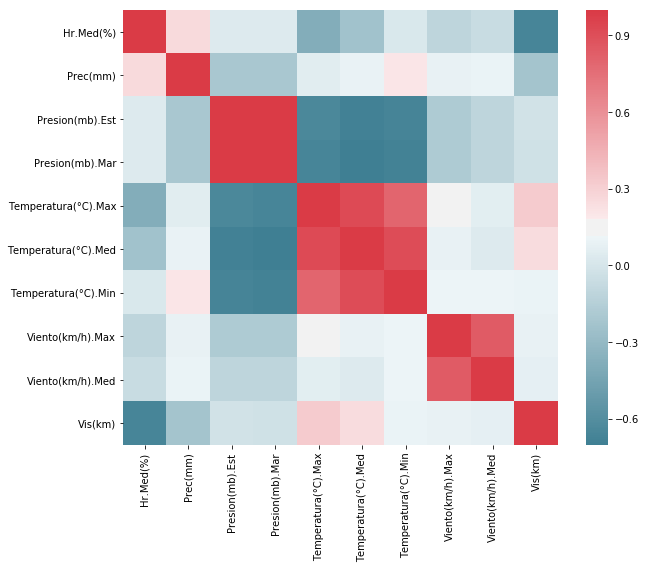

In [131]:
corr = rain_junin_clean.corr()
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

In [132]:
rain_junin_clean.columns

Index(['Hr.Med(%)', 'Prec(mm)', 'Presion(mb).Est', 'Presion(mb).Mar',
       'Temperatura(°C).Max', 'Temperatura(°C).Med', 'Temperatura(°C).Min',
       'Viento(km/h).Max', 'Viento(km/h).Med', 'Vis(km)'],
      dtype='object')

A continuación, se seleccionarán las features más representativas a partir de "SelectKBest"

In [ ]:
y_orig = rain_junin_clean['Prec(mm)']  #columnas objetivo
X_orig = rain_junin_clean.drop('Prec(mm)', axis=1)  #columnas independientes
#X1 = X_orig.drop('Fecha', axis=1)
#X1.describe()

In [ ]:
model = DecisionTreeRegressor()
model.fit(X_orig,y_orig)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_orig.columns)
feat_importances.nlargest(9).plot(kind='barh')
f1 = feat_importances.nlargest(6)
plt.show()
X2 = X_orig[f1.index]
X2

A continuación se normalizan los valores anteriores.

In [ ]:
scaler = Normalizer().fit(X2)
#scaler = StandardScaler().fit(X2)
std_X2 = scaler.transform(X2)
std_X2

# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# sc_X_train = sc.fit_transform(X_train)
# sc_X_test = sc.transform(X_test)

Como arrojaban errores de que no podía ajustarse el algoritmo de regresión lineal o logística a los datos anteriores por ser del tipo flotante, se los redondeó de la siguiente manera:

In [ ]:
X3 = np.around(X2, decimals = 0, out = None)
X3 = X3.astype(int)
y3 = np.around(y_orig, decimals = 0, out = None)
y3 = y3.astype(int)

Los set de train y test se repartieron en 70% y 30% respectivamente:

In [ ]:
# split training dataset into test and train 
# (we won't be using testing sets here, because of the cross-validation; but it couldn be useful)
X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.3, random_state=42) ##test_size conviene 0.2???

La regresión Logística dió muy buenos resultados. Cabe resaltar que el accuracy es una métrica de Clasificación y en este caso estamos lidiando con Regresión.

In [ ]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class = 'auto', random_state = 42)
lr_param = {'penalty':('l2', 'l1'), 'C':[1.0], 'warm_start':[True, False]}

lr_clf = GridSearchCV(lr, lr_param, cv=5, iid=False)
start = time()
lr_clf.fit(X_train, y_train)
best_lr_clf = lr_clf.best_estimator_
print('Best Log Reg: ', lr_clf.best_score_)
print(best_lr_clf)
results = results.append({'clf': best_lr_clf, 'best_res': lr_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])

print("Log Reg tomó %.2f segundos para %d configuraciones de parámetros candidatos."
      % (time() - start, len(lr_clf.cv_results_['params'])))
for i in range(len(lr_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(lr_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  lr_clf.cv_results_['mean_test_score'][candidato],
                  lr_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(lr_clf.cv_results_['params'][candidato]))
        print("")


In [ ]:
from sklearn.linear_model import LogisticRegression

results = pd.DataFrame(columns=('clf', 'best_res'))

lr_clf2 = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=True)

lr_clf2.fit(X_train, y_train)
results = results.append({'clf': lr_clf2}, ignore_index=True)

print('Logistic Regression:')
print('Score para entrenamiento: %.2f' % 
      accuracy_score(y_train, lr_clf2.predict(X_train)))
print('Score para evaluación: %.2f' %
      accuracy_score(y_test, lr_clf2.predict(X_test)))

In [ ]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Stochastic Gradient
from sklearn.linear_model import SGDClassifier


#parameters_SGDC = {'loss':('hinge', 'log'), 'max_iter': [10000], 'tol': [0.001]}
parameters_SGDC = {'loss':('hinge', 'log'), 'learning_rate':('adaptive', 'optimal', 'invscaling'),
              'penalty':('l2', 'l1', 'elasticnet'), 'alpha':[0.0001], 'max_iter': [10000], 
              'eta0': [0.1], 'tol': [0.001]}
SGDC = SGDClassifier(random_state=42)
SGDC_clf = GridSearchCV(SGDC, parameters_SGDC, cv=5, iid = False, return_train_score = True)
start = time()
SGDC_clf.fit(X_train, y_train)
best_SGDC_clf = SGDC_clf.best_estimator_

print('Best SGDC score: ', SGDC_clf.best_score_)
print(best_SGDC_clf)
results = results.append({'clf': best_SGDC_clf, 'best_res': SGDC_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])
print("")

print("GridSearchCV tomó %.2f segundos para %d configuraciones de parámetros candidatos."
      % (time() - start, len(SGDC_clf.cv_results_['params'])))
for i in range(len(SGDC_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(SGDC_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  SGDC_clf.cv_results_['mean_test_score'][candidato],
                  SGDC_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(SGDC_clf.cv_results_['params'][candidato]))
        print("")

In [ ]:
from sklearn.linear_model import SGDClassifier

results = pd.DataFrame(columns=('clf', 'best_res'))

SGDC_clf2 = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge',
       max_iter=10000, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

SGDC_clf2.fit(X_train, y_train)
results = results.append({'clf': SGDC_clf2}, ignore_index=True)

print('Stochastic Descendent Gradient:')
print('Score para entrenamiento: %.2f' % 
      accuracy_score(y_train, SGDC_clf2.predict(X_train)))
print('Score para evaluación: %.2f' %
      accuracy_score(y_test, SGDC_clf2.predict(X_test)))

In [ ]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Linear Regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr_param = {}

lr_clf = GridSearchCV(lr, lr_param, cv=5, iid=False)
start = time()
lr_clf.fit(X_train, y_train)
best_lr_clf = lr_clf.best_estimator_
print('Best Log Reg: ', lr_clf.best_score_)
print(best_lr_clf)
results = results.append({'clf': best_lr_clf, 'best_res': lr_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])

print("Log Reg tomó %.2f segundos para %d configuraciones de parámetros candidatos."
      % (time() - start, len(lr_clf.cv_results_['params'])))
for i in range(len(lr_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(lr_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  lr_clf.cv_results_['mean_test_score'][candidato],
                  lr_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(lr_clf.cv_results_['params'][candidato]))
        print("")


In [ ]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Random Forest - Regression
from sklearn.ensemble import RandomForestRegressor as RFR #Javier: Leer y probar otros parámetros.
from scipy.stats import randint as sp_randint

tree_param_dist = {'max_depth': sp_randint(1, 25),
#                    'max_features': sp_randint(4, 10),
                   'min_samples_split': sp_randint(2, 25),
                   'bootstrap': [True, False],
                   'warm_start': [True, False],}
#                    'criterion': ['gini', 'entropy']}

# tree_param_dist = {}
tree = RFR(random_state=42, n_estimators=30, min_samples_leaf=1)

tree_clf = RandomizedSearchCV(tree, param_distributions=tree_param_dist, n_iter=30, cv=10, iid=False) 

# start = time()
tree_clf.fit(X_train, y_train)

best_tree_clf = tree_clf.best_estimator_
print('Best Decision Tree: ', tree_clf.best_score_)
print(best_tree_clf)
results = results.append({'clf': best_tree_clf, 'best_res': tree_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])

# print("Regression Tree tomó %.2f segundos para %d configuraciones de parámetros candidatos."
#       % (time() - start, len(tree_clf.cv_results_['params'])))
for i in range(len(tree_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(tree_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  tree_clf.cv_results_['mean_test_score'][candidato],
                  tree_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(tree_clf.cv_results_['params'][candidato]))
        print("")

In [ ]:
results = pd.DataFrame(columns=('clf', 'best_res'))

## Linear SVC
from sklearn.svm import LinearSVR

lsvr = LinearSVR(random_state=42)
lsvr_param = {}

lsvr_clf = RandomizedSearchCV(lsvr, lsvr_param, n_iter=30, cv=5, iid=False)
start = time()
lsvr_clf.fit(X_train, y_train)
best_lsvr_clf = lsvr_clf.best_estimator_
print('Best Linear SVR: ', lsvr_clf.best_score_)
print(best_lsvr_clf)
results = results.append({'clf': best_lsvr_clf, 'best_res': lsvr_clf.best_score_}, ignore_index=True)

print('The best classifier so far is: ')
print(results.loc[results['best_res'].idxmax()]['clf'])

print("Linear SVR tomó %.2f segundos para %d configuraciones de parámetros candidatos."
      % (time() - start, len(lsvr_clf.cv_results_['params'])))
for i in range(len(lsvr_clf.cv_results_['params'])+1):
    candidatos = np.flatnonzero(lsvr_clf.cv_results_['rank_test_score'] == i)
    for candidato in candidatos:
        print("El modelo con el ranking: {0}".format(i))
        print("Scores de validación Medios: {0:.3f} (std: {1:.3f})".format(
                  lsvr_clf.cv_results_['mean_test_score'][candidato],
                  lsvr_clf.cv_results_['std_test_score'][candidato]))
        print("Parametros: {0}".format(lsvr_clf.cv_results_['params'][candidato]))
        print("")


#### Combinacion de datasets

1) Combinar ambos datasets a partir de features comunes a ambos

2) Validar la correcctitud de los datos fusionados

3) Aplicar tecnicas de selección y extraccion de features  

4) Analizar features data / target 

5) dividir dataset (training, validation, test)  

6) analizar y elegir el modelo mas apropiado, entrenarlo y analizar resultados


---------------

In [40]:
rain_junin_2 = pd.read_csv("rain_junin.csv", parse_dates = ["Fecha"], index_col=[0])
fecha1 = rain_junin_2.index.max()
fecha2 = rain_junin_2.index.min()
rain_teo = pd.read_csv("rain_teodelina.csv", parse_dates = ["date"])
rain_teo = rain_teo[rain_teo.date>=fecha2]
rain_teo = rain_teo[rain_teo.date<=fecha1]
rain_junin_2['rain_teo'] = rain_teo['rain'].values
rain_junin_2['m'] = rain_junin_2.index.month_name()
rain_junin_2.describe(include='all')

,Hr.Med(%),Prec(mm),Presion(mb).Est,Presion(mb).Mar,Temperatura(°C).Max,Temperatura(°C).Med,Temperatura(°C).Min,Viento(km/h).Max,Viento(km/h).Med,Vis(km),rain_teo,m
count,1066.000000,1050.000000,1066.000000,1066.000000,1066.000000,1066.000000,1066.000000,1065.000000,1066.000000,1066.000000,1096.000000,1096
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,March
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93
mean,69.875141,3.424095,1005.528424,1015.193621,23.837523,16.232176,10.133865,24.056901,14.788180,12.209287,4.578467,NaN
std,12.923685,11.106181,6.087682,6.271942,6.503449,5.732337,5.833879,8.268677,5.480464,2.315869,15.839758,NaN
min,29.400000,0.000000,991.100000,1000.400000,8.600000,2.800000,-6.200000,7.600000,2.800000,2.600000,0.000000,NaN
25%,60.900000,0.000000,1001.400000,1010.900000,18.825000,11.600000,6.000000,18.300000,10.900000,11.100000,0.000000,NaN
50%,70.500000,0.000000,1005.100000,1014.850000,24.200000,16.450000,10.200000,24.100000,14.100000,12.600000,0.000000,NaN
75%,79.500000,0.000000,1009.600000,1019.400000,29.200000,20.800000,14.875000,29.400000,18.500000,13.900000,0.000000,NaN


In [41]:
def normalize_col(float_array):
    min_max_scaler = MinMaxScaler()
    return min_max_scaler.fit_transform(float_array)

col_names = [ 'Hr.Med(%)', 'Prec(mm)', 'Presion(mb).Est', 'Presion(mb).Mar', 'Temperatura(°C).Max',
             'Temperatura(°C).Med', 'Temperatura(°C).Min', 'Viento(km/h).Max', 'Viento(km/h).Med', 'Vis(km)' ]
for col_name in col_names:
    rain_junin_2[col_name] = normalize_col(rain_junin_2[col_name].values.astype(float).reshape(-1, 1))

In [42]:
rain_junin_2.head(5)

,Hr.Med(%),Prec(mm),Presion(mb).Est,Presion(mb).Mar,Temperatura(°C).Max,Temperatura(°C).Med,Temperatura(°C).Min,Viento(km/h).Max,Viento(km/h).Med,Vis(km),rain_teo,m
Fecha,,,,,,,,,,,,
2016-01-01,0.619883,0.052008,0.267062,0.263768,0.808511,0.809160,0.857143,0.440087,0.387187,0.671233,0,January
2016-01-02,0.561404,0.000000,0.323442,0.318841,0.833333,0.870229,0.923345,0.398693,0.459610,0.698630,0,January
2016-01-03,0.726608,0.000000,0.293769,0.289855,0.815603,0.797710,0.912892,0.640523,0.526462,0.684932,6,January
2016-01-04,0.907895,0.000000,0.252226,0.249275,0.648936,0.740458,0.940767,0.233115,0.220056,0.534247,0,January
2016-01-05,0.733918,0.065174,0.341246,0.336232,0.702128,0.793893,0.905923,0.359477,0.323120,0.595890,90,January
2016-01-06,0.347953,0.000000,0.477745,0.472464,0.726950,0.725191,0.689895,0.283224,0.401114,0.773973,5,January
2016-01-07,0.448830,0.000000,0.451039,0.446377,0.687943,0.709924,0.703833,0.193900,0.183844,0.773973,0,January
2016-01-08,0.535088,0.005267,0.338279,0.333333,0.723404,0.751908,0.808362,0.156863,0.153203,0.719178,0,January
2016-01-09,0.733918,0.000000,0.409496,0.405797,0.762411,0.698473,0.836237,0.359477,0.303621,0.719178,0,January


In [43]:
rain_junin_2 = pd.get_dummies(data=rain_junin_2,columns=['m'])

In [44]:
rain_junin_2.head(5)

,Hr.Med(%),Prec(mm),Presion(mb).Est,Presion(mb).Mar,Temperatura(°C).Max,Temperatura(°C).Med,Temperatura(°C).Min,Viento(km/h).Max,Viento(km/h).Med,Vis(km),...,m_December,m_February,m_January,m_July,m_June,m_March,m_May,m_November,m_October,m_September
Fecha,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0.619883,0.052008,0.267062,0.263768,0.808511,0.809160,0.857143,0.440087,0.387187,0.671233,...,0,0,1,0,0,0,0,0,0,0
2016-01-02,0.561404,0.000000,0.323442,0.318841,0.833333,0.870229,0.923345,0.398693,0.459610,0.698630,...,0,0,1,0,0,0,0,0,0,0
2016-01-03,0.726608,0.000000,0.293769,0.289855,0.815603,0.797710,0.912892,0.640523,0.526462,0.684932,...,0,0,1,0,0,0,0,0,0,0
2016-01-04,0.907895,0.000000,0.252226,0.249275,0.648936,0.740458,0.940767,0.233115,0.220056,0.534247,...,0,0,1,0,0,0,0,0,0,0
2016-01-05,0.733918,0.065174,0.341246,0.336232,0.702128,0.793893,0.905923,0.359477,0.323120,0.595890,...,0,0,1,0,0,0,0,0,0,0
2016-01-06,0.347953,0.000000,0.477745,0.472464,0.726950,0.725191,0.689895,0.283224,0.401114,0.773973,...,0,0,1,0,0,0,0,0,0,0
2016-01-07,0.448830,0.000000,0.451039,0.446377,0.687943,0.709924,0.703833,0.193900,0.183844,0.773973,...,0,0,1,0,0,0,0,0,0,0
2016-01-08,0.535088,0.005267,0.338279,0.333333,0.723404,0.751908,0.808362,0.156863,0.153203,0.719178,...,0,0,1,0,0,0,0,0,0,0
2016-01-09,0.733918,0.000000,0.409496,0.405797,0.762411,0.698473,0.836237,0.359477,0.303621,0.719178,...,0,0,1,0,0,0,0,0,0,0


In [48]:
junin_2_miss_val_count = rain_junin_2.isnull().sum()
junin_2_miss_val_count[junin_2_miss_val_count > 0]

Hr.Med(%)              30
Prec(mm)               46
Presion(mb).Est        30
Presion(mb).Mar        30
Temperatura(°C).Max    30
Temperatura(°C).Med    30
Temperatura(°C).Min    30
Viento(km/h).Max       31
Viento(km/h).Med       30
Vis(km)                30
dtype: int64

In [65]:
rain_junin_2.dropna(axis=0, inplace=True, how='any', subset=['Prec(mm)', 'Viento(km/h).Max'])

In [66]:
junin_2_miss_val_count = rain_junin_2.isnull().sum()
junin_2_miss_val_count[junin_2_miss_val_count > 0]

Series([], dtype: int64)

In [89]:
y_orig_junin2 = Binarizer().transform(rain_junin_2['rain_teo'].values.reshape(-1, 1)).ravel() #columnas objetivo
X_orig_junin2 = rain_junin_2.drop('rain_teo', axis=1)  #columnas independientes

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_orig_junin2, y_orig_junin2, test_size=0.2, random_state=42)

#### Stochastic Gradient Descent 

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

# Exploración de hiperparámetros de SGD para función de coste "hinge"

Mejor conjunto de parámetros:
{'alpha': 0.00035, 'eta0': 0.1, 'learning_rate': 'constant'}

Score f1
Mejor valor: 0.519

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.886 

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       177
           1       0.74      0.42      0.54        33

   micro avg       0.89      0.89      0.89       210
   macro avg       0.82      0.70      0.74       210
weighted avg       0.87      0.89      0.87       210




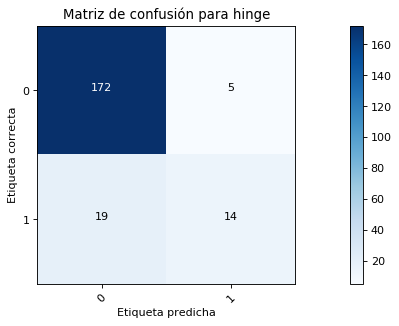

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

# Exploración de hiperparámetros de SGD para función de coste "log"

Mejor conjunto de parámetros:
{'alpha': 0.00035, 'eta0': 0.1, 'learning_rate': 'constant'}

Score f1
Mejor valor: 0.523

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.881 

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       177
           1       0.79      0.33      0.47        33

   micro avg       0.88      0.88      0.88       210
   macro avg       0.84      0.66      0.70       210
weighted avg       0.87      0.88      0.86       210




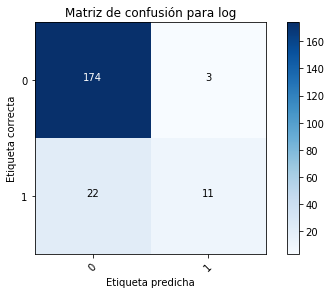

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

# Exploración de hiperparámetros de SGD para función de coste "perceptron"

Mejor conjunto de parámetros:
{'alpha': 0.001, 'eta0': 0.001, 'learning_rate': 'adaptive'}

Score f1
Mejor valor: 0.597

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.890 

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       177
           1       0.62      0.76      0.68        33

   micro avg       0.89      0.89      0.89       210
   macro avg       0.79      0.84      0.81       210
weighted avg       0.90      0.89      0.89       210




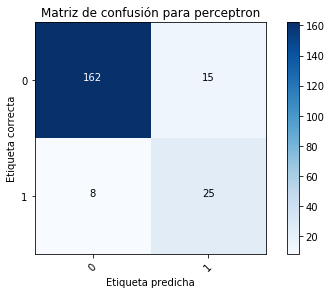

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', ave

# Exploración de hiperparámetros de SGD para función de coste "epsilon_insensitive"

Mejor conjunto de parámetros:
{'alpha': 0.00035, 'eta0': 0.1, 'learning_rate': 'constant'}

Score f1
Mejor valor: 0.225

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.871 

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       177
           1       0.88      0.21      0.34        33

   micro avg       0.87      0.87      0.87       210
   macro avg       0.87      0.60      0.64       210
weighted avg       0.87      0.87      0.84       210




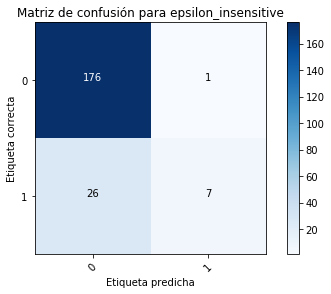


El mejor clasificador es: 

Funcion loss: perceptron 
Conjunto de parametros: SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
       l1_ratio=0.15, learning_rate='adaptive', loss='perceptron',
       max_iter=2000, n_iter=None, n_iter_no_change=5, n_jobs=None,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False) 
Score: 0.5966681398651542



In [114]:
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
scoring_value=0.0
score='f1' # accuracy, precision, recall, roc-auc
results_SGD = pd.DataFrame(columns=('clf', 'best_acc'))

for idx, loss in enumerate(('hinge', 'log', 'perceptron', 'epsilon_insensitive'), start=1):
    exploring_params = {
        'learning_rate': ['constant', 'optimal', 'adaptive'],
        'eta0': [0.1, 0.01, 0.001, 0.0002 ],  # Tasa de entrenamiento
        'alpha': [0.1, 0.01, 0.001, 0.00035]  # Tasa de regularización
    }
    m = SGDClassifier(loss=loss, tol=1e-3, max_iter=2000, random_state=42)
    model = GridSearchCV(m, exploring_params, cv=5, scoring=score)
    model.fit(X_train, y_train)
    
    print("# Exploración de hiperparámetros de SGD para función de coste \"%s\"" % loss, end="\n\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")
    print("Score %s" % score) 
    print("Mejor valor: %0.3f" %  model.best_score_, end="\n\n") # 

    if(model.best_score_ > scoring_value):
        results_SGD = results_SGD.append({'clf': model.best_estimator_, 'best_acc': model.best_score_,
                                          'loss_func': loss},
                                          ignore_index=True)

    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test, model.predict(X_test)
    print("Exactitud para conjunto de test: %0.3f " % accuracy_score(y_true, y_pred), end="\n\n")
    print(classification_report(y_true, y_pred), end="\n\n")
    
    plt.subplot(1, 1, 1)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                          classes=('0', '1'), title="Matriz de confusión para %s" % loss)
    plt.show()
    
    print("================================================", end="\n\n")

print('El mejor clasificador es: ', end="\n\n")
print("Funcion loss: %s " % results_SGD.loc[results_SGD['best_acc'].idxmax()]['loss_func'], end="\n")
print("Conjunto de parametros: %s " % results_SGD.loc[results_SGD['best_acc'].idxmax()]['clf'], end="\n")
print("Score: %s" %results_SGD.loc[results_SGD['best_acc'].idxmax()]['best_acc'], end="\n\n")

#### Decision Tree

# Exploración de hiperparámetros de DT para profundidad del arbol "2"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}

Score f1
Mejor valor: 0.606

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.857 

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       177
           1       0.53      0.70      0.61        33

   micro avg       0.86      0.86      0.86       210
   macro avg       0.74      0.79      0.76       210
weighted avg       0.88      0.86      0.86       210




/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


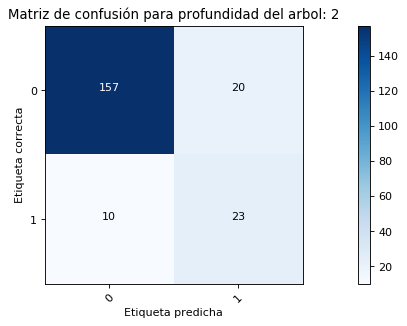


# Exploración de hiperparámetros de DT para profundidad del arbol "5"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}

Score f1
Mejor valor: 0.606

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.857 

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       177
           1       0.53      0.70      0.61        33

   micro avg       0.86      0.86      0.86       210
   macro avg       0.74      0.79      0.76       210
weighted avg       0.88      0.86      0.86       210




/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


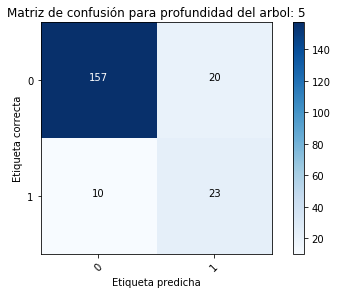


# Exploración de hiperparámetros de DT para profundidad del arbol "6"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}

Score f1
Mejor valor: 0.606

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.857 

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       177
           1       0.53      0.70      0.61        33

   micro avg       0.86      0.86      0.86       210
   macro avg       0.74      0.79      0.76       210
weighted avg       0.88      0.86      0.86       210




/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


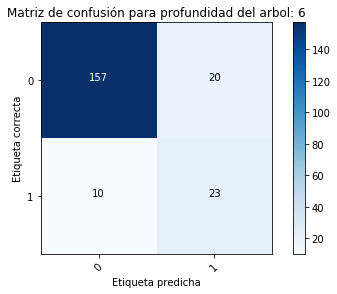


# Exploración de hiperparámetros de DT para profundidad del arbol "7"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}

Score f1
Mejor valor: 0.606

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.857 

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       177
           1       0.53      0.70      0.61        33

   micro avg       0.86      0.86      0.86       210
   macro avg       0.74      0.79      0.76       210
weighted avg       0.88      0.86      0.86       210




/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


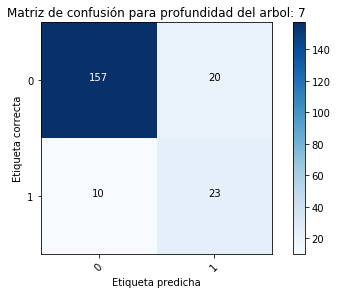


# Exploración de hiperparámetros de DT para profundidad del arbol "8"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}

Score f1
Mejor valor: 0.606

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.857 

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       177
           1       0.53      0.70      0.61        33

   micro avg       0.86      0.86      0.86       210
   macro avg       0.74      0.79      0.76       210
weighted avg       0.88      0.86      0.86       210




/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


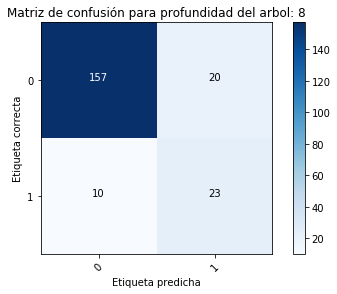


# Exploración de hiperparámetros de DT para profundidad del arbol "10"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_leaf_nodes': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}

Score f1
Mejor valor: 0.606

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.857 

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       177
           1       0.53      0.70      0.61        33

   micro avg       0.86      0.86      0.86       210
   macro avg       0.74      0.79      0.76       210
weighted avg       0.88      0.86      0.86       210




/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


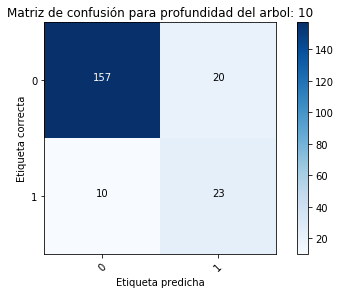


El mejor clasificador es: 

Profundidad del arbol: 2 
Conjunto de parametros: DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=2, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best') 
Score: 0.6059312549267436



In [125]:
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
scoring_value=0.0
score='f1' # accuracy, precision, recall, roc-auc
results_DT = pd.DataFrame(columns=('clf', 'best_acc'))

for idx, depth in enumerate((2, 5, 6, 7, 8, 10), start=1):
    tree_param = {
              'criterion' : [ 'gini', 'entropy' ], 
              'min_samples_leaf' : [ 1, 2, 5],
              'min_samples_split' : [ 2, 3, 5, 10, 50, 100 ],
              'max_leaf_nodes': [ 2, 5, 10, 30, 40, 50],
              'class_weight' : [ 'balanced' ]
    }
    m = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model = GridSearchCV(m, tree_param, scoring=score, cv=5)
    model.fit(X_train, y_train)
    
    print("# Exploración de hiperparámetros de DT para profundidad del arbol \"%d\"" % depth, end="\n\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")
    print("Score %s" % score) 
    print("Mejor valor: %0.3f" %  model.best_score_, end="\n\n") # 

    if(model.best_score_ > scoring_value):
        results_DT = results_DT.append({'clf': model.best_estimator_, 'best_acc': model.best_score_,
                                          'tree_depth': depth},
                                          ignore_index=True)

    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test, model.predict(X_test)
    print("Exactitud para conjunto de test: %0.3f " % accuracy_score(y_true, y_pred), end="\n\n")
    print(classification_report(y_true, y_pred), end="\n\n")
    
    plt.subplot(1, 1, 1)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                          classes=('0', '1'), title="Matriz de confusión para profundidad del arbol: %d" % depth)
    plt.show()
    
    print("================================================", end="\n\n")

print('El mejor clasificador es: ', end="\n\n")
print("Profundidad del arbol: %d " % results_DT.loc[results_DT['best_acc'].idxmax()]['tree_depth'], end="\n")
print("Conjunto de parametros: %s " % results_DT.loc[results_DT['best_acc'].idxmax()]['clf'], end="\n")
print("Score: %s" %results_DT.loc[results_DT['best_acc'].idxmax()]['best_acc'], end="\n\n")

#### Random Forest

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros de DT para profundidad del arbol "2"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 15}

Score f1
Mejor valor: 0.628

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.848 

              precision    recall  f1-score   support

           0       0.94      0.87      0.91       177
           1       0.51      0.73      0.60        33

   micro avg       0.85      0.85      0.85       210
   macro avg       0.73      0.80      0.75       210
weighted avg       0.88      0.85      0.86       210




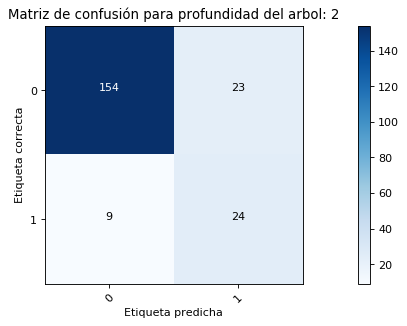

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros de DT para profundidad del arbol "4"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_leaf_nodes': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 15}

Score f1
Mejor valor: 0.626

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.848 

              precision    recall  f1-score   support

           0       0.94      0.87      0.91       177
           1       0.51      0.73      0.60        33

   micro avg       0.85      0.85      0.85       210
   macro avg       0.73      0.80      0.75       210
weighted avg       0.88      0.85      0.86       210




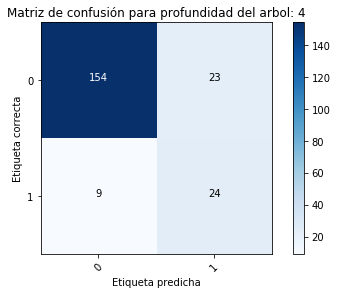

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros de DT para profundidad del arbol "5"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 15}

Score f1
Mejor valor: 0.632

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.857 

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       177
           1       0.53      0.73      0.62        33

   micro avg       0.86      0.86      0.86       210
   macro avg       0.74      0.80      0.76       210
weighted avg       0.88      0.86      0.87       210




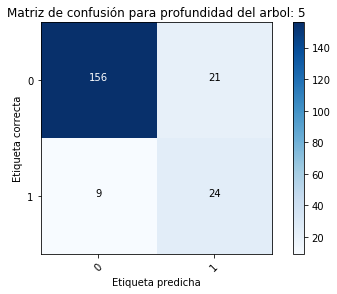

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros de DT para profundidad del arbol "6"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 15}

Score f1
Mejor valor: 0.626

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.852 

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       177
           1       0.52      0.73      0.61        33

   micro avg       0.85      0.85      0.85       210
   macro avg       0.73      0.80      0.76       210
weighted avg       0.88      0.85      0.86       210




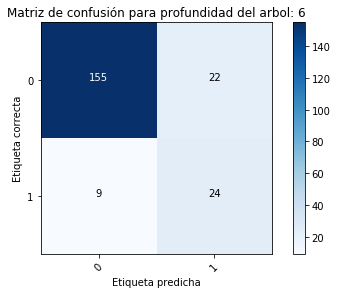

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros de DT para profundidad del arbol "7"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 15}

Score f1
Mejor valor: 0.626

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.852 

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       177
           1       0.52      0.73      0.61        33

   micro avg       0.85      0.85      0.85       210
   macro avg       0.73      0.80      0.76       210
weighted avg       0.88      0.85      0.86       210




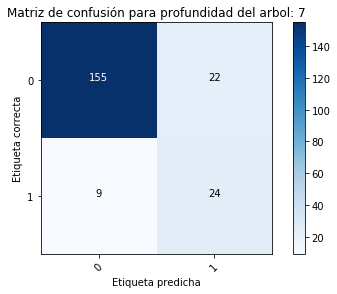

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros de DT para profundidad del arbol "8"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 15}

Score f1
Mejor valor: 0.626

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.852 

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       177
           1       0.52      0.73      0.61        33

   micro avg       0.85      0.85      0.85       210
   macro avg       0.73      0.80      0.76       210
weighted avg       0.88      0.85      0.86       210




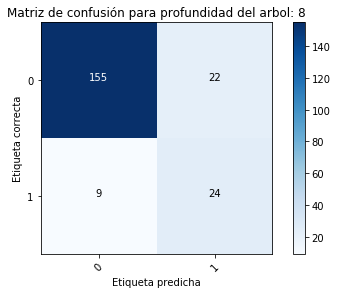

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros de DT para profundidad del arbol "10"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 15}

Score f1
Mejor valor: 0.628

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.867 

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       177
           1       0.56      0.67      0.61        33

   micro avg       0.87      0.87      0.87       210
   macro avg       0.75      0.79      0.77       210
weighted avg       0.88      0.87      0.87       210




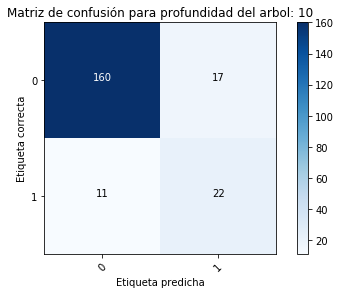

/home/architect/anaconda3/envs/diplodatos/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Exploración de hiperparámetros de DT para profundidad del arbol "15"

Mejor conjunto de parámetros:
{'class_weight': 'balanced', 'criterion': 'gini', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 15}

Score f1
Mejor valor: 0.626

Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):

Exactitud para conjunto de test: 0.852 

              precision    recall  f1-score   support

           0       0.95      0.88      0.91       177
           1       0.52      0.73      0.61        33

   micro avg       0.85      0.85      0.85       210
   macro avg       0.73      0.80      0.76       210
weighted avg       0.88      0.85      0.86       210




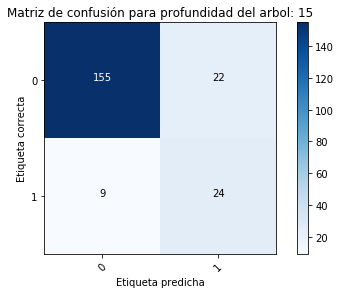


El mejor clasificador es: 

Profundidad del arbol: 5 
Conjunto de parametros: RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=10, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False) 
Score: 0.6318482306003752



In [129]:
plt.figure(figsize=(14, 4), dpi= 80, facecolor='w', edgecolor='k')
scoring_value=0.0
score='f1' # accuracy, precision, recall, roc-auc
results_RF = pd.DataFrame(columns=('clf', 'best_acc'))

for idx, depth in enumerate((2, 4, 5, 6, 7, 8, 10, 15), start=1):
    rf_param = {
              'criterion' : [ 'gini', 'entropy' ], 
              'min_samples_leaf' : [ 1, 2, 5 ],
              'min_samples_split' : [ 2, 3, 5, 10, 50, 100 ], #  
              'max_leaf_nodes': [ 2, 5, 10, 30, 40, 50 ], #
              'n_estimators' : [ 3, 5, 8, 10, 15 ], 
              'class_weight' : [ 'balanced' ]
              #'min_impurity_split': [ 0.00001, 0.000001, 0.0000001 , 0.00000001 ]
    }
    m = RF(max_depth=depth, random_state=42, n_jobs=-1)
    model = GridSearchCV(m, rf_param, scoring=score, cv=5)
    model.fit(X_train, y_train)
    
    print("# Exploración de hiperparámetros de DT para profundidad del arbol \"%d\"" % depth, end="\n\n")
    
    print("Mejor conjunto de parámetros:")
    print(model.best_params_, end="\n\n")
    print("Score %s" % score) 
    print("Mejor valor: %0.3f" %  model.best_score_, end="\n\n") # 

    if(model.best_score_ > scoring_value):
        results_RF = results_RF.append({'clf': model.best_estimator_, 'best_acc': model.best_score_,
                                          'tree_depth': depth},
                                          ignore_index=True)

    print("Reporte de clasificación para el mejor clasificador (sobre conjunto de evaluación):", end="\n\n")
    y_true, y_pred = y_test, model.predict(X_test)
    print("Exactitud para conjunto de test: %0.3f " % accuracy_score(y_true, y_pred), end="\n\n")
    print(classification_report(y_true, y_pred), end="\n\n")
    
    plt.subplot(1, 1, 1)
    plot_confusion_matrix(confusion_matrix(y_true, y_pred),
                          classes=('0', '1'), title="Matriz de confusión para profundidad del arbol: %d" % depth)
    plt.show()
    
    print("================================================", end="\n\n")

print('El mejor clasificador es: ', end="\n\n")
print("Profundidad del arbol: %d " % results_RF.loc[results_RF['best_acc'].idxmax()]['tree_depth'], end="\n")
print("Conjunto de parametros: %s " % results_RF.loc[results_RF['best_acc'].idxmax()]['clf'], end="\n")
print("Score: %s" %results_RF.loc[results_RF['best_acc'].idxmax()]['best_acc'], end="\n\n")

Para este ultimo ejercicio se combinaron ambos datasets, al de Junin se le agrego el de Teodelina, ya que la cantidad de features (columnas) del primer dataset es mayor que la del segundo, y porque de ser en sentido opuesto 
quedarian todas las features agredadas al dataset de Teodelina con valores N/A. Razon por la cual se filtro el dataset de Teodelina para el rango de fechas en el que se tomaron las mediciones del dataset de Junin.                  
Por otro lado se agrego tambien una feature que indica el mes en que se registro la medida (daria la nocion de si el registro fue tomado en un mes es propenzo a lluvias o no dentro del año hidrico). Esta feature fue convertida de categorica a un indicador dummy (0/1) para alimentar a los modelos.                                                                                                           
Otro preprocesamiento que se realizo fue el de escalar entre 0 y 1 todos los valores numericos de las demases columnas dentro del dataset. Por ultimo se eliminaron las filas que tenian valores de N/A en la columna de 'Prec(mm)' y 'Viento(km/h).Max', ya que son el 4% del total de registros y no tienen inicidencia alguna el removerlos ademas de no sumar valor al ajuste del dataset en los diferentes modelos.                                           
Finalmente se binarizo la columna que se agrego (lluvia en Teodelina) entre 0 y 1 para poder predecir justamente esto, si llueve o no en Teodelina dado el resto de features provista a cada modelo.                                 
Se probo solo con tres modelos, SGD, Decision Tree, y Random Forest, para los cuales dado el desbalance de clases a clasificar (cantidad bastante mayor de dias sin llover que los dias que si llovio) si tomo como "scoring" del GridSearch el "F1" y el de mejor perfomance fue el Random Forest.